# Analyzing Our Dataset and Distribution

In [3]:
# Import libararies
import tensorflow as tf
import tensorflow_hub as hub
import re
import pandas as pd # CSV file I/O (pd.read_csv)
from nltk.corpus import stopwords
import numpy as np
import sklearn
import nltk
from keras import backend as K
from keras.layers import Input, Embedding, BatchNormalization, LSTM, Dense, Concatenate
from keras.models import Model
import keras.layers as layers
from keras.utils import plot_model
from collections import Counter
from keras.callbacks import TensorBoard

from keras.utils import plot_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,confusion_matrix
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

C:\Users\Adil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
with open('News_Category_Dataset_v2.json') as json_file:  
    train_data = json.load(json_file)

In [4]:
news=pd.DataFrame(train_data)

In [5]:
pd.set_option('display.max_colwidth', -1)

In [6]:
news.groupby(by='category').size()

category
ARTS              1509 
ARTS & CULTURE    1339 
BLACK VOICES      4528 
BUSINESS          5937 
COLLEGE           1144 
COMEDY            5175 
CRIME             3405 
CULTURE & ARTS    1030 
DIVORCE           3426 
EDUCATION         1004 
ENTERTAINMENT     16058
ENVIRONMENT       1323 
FIFTY             1401 
FOOD & DRINK      6226 
GOOD NEWS         1398 
GREEN             2622 
HEALTHY LIVING    6694 
HOME & LIVING     4195 
IMPACT            3459 
LATINO VOICES     1129 
MEDIA             2815 
MONEY             1707 
PARENTING         8677 
PARENTS           3955 
POLITICS          32739
QUEER VOICES      6314 
RELIGION          2556 
SCIENCE           2178 
SPORTS            4884 
STYLE             2254 
STYLE & BEAUTY    9649 
TASTE             2096 
TECH              2082 
THE WORLDPOST     3664 
TRAVEL            9887 
WEDDINGS          3651 
WEIRD NEWS        2670 
WELLNESS          17827
WOMEN             3490 
WORLD NEWS        2177 
WORLDPOST         2579 
dtype: 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

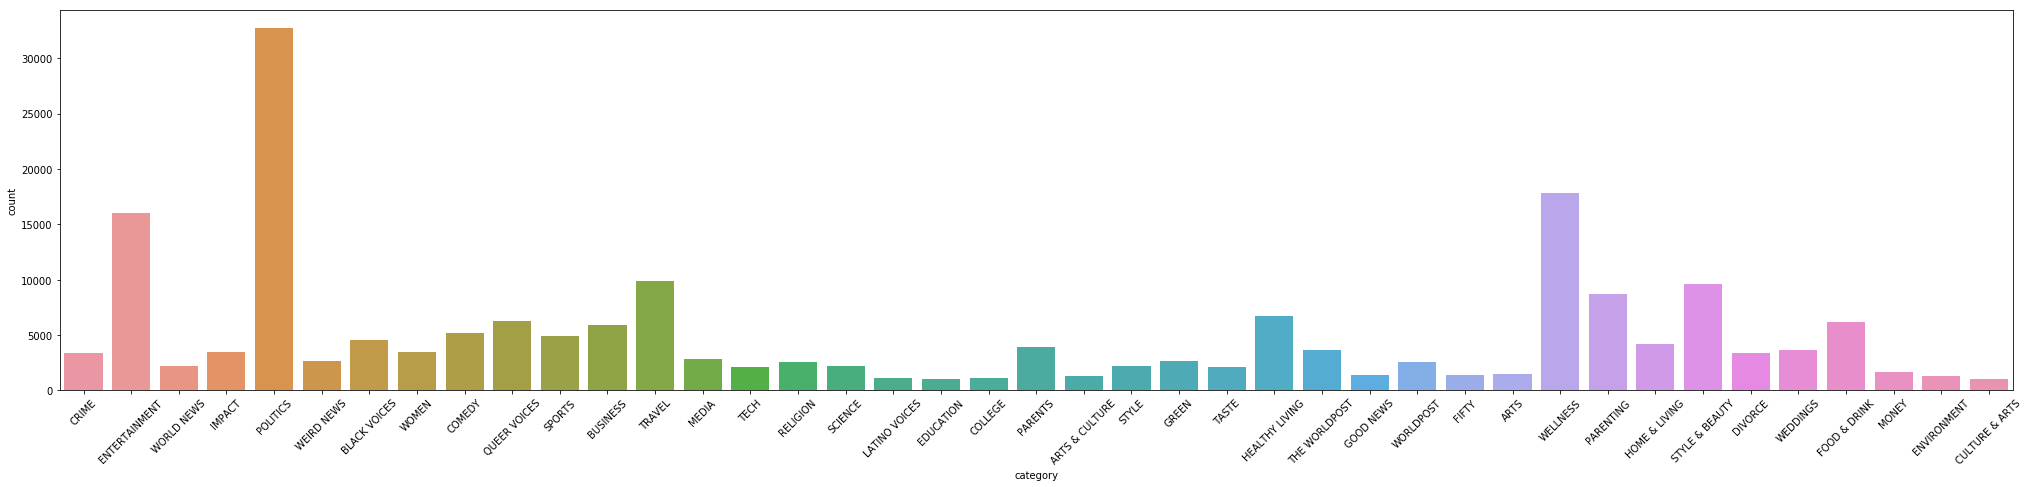

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(35,7))
sns.countplot(x = 'category', data = news)
plt.xticks(rotation=45)

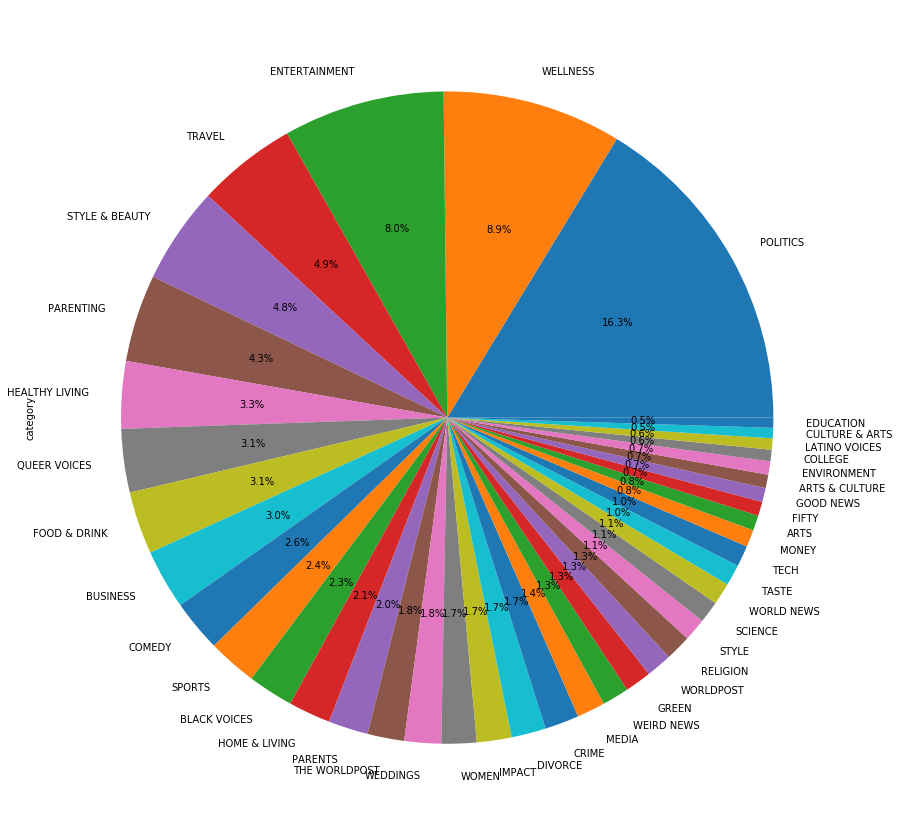

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
news['category'].value_counts().plot.pie( autopct = '%1.1f%%')

## At this point in order to work with data easily I just take 5 class samples from big Dataset and I created train_.txt and validation_.txt and I also put my sample into the google drive

### Preparing Dataset

In [8]:
with open('train_.txt') as json_file:  
    train_data = json.load(json_file)

In [9]:
from random import shuffle
shuffle(train_data)

In [10]:
a=[]
for i in train_data:
    a.append(i['category'])
classes=set(a)

In [11]:
classes

{'BLACK VOICES', 'COMEDY', 'HEALTHY LIVING', 'SPORTS', 'WORLD NEWS'}

In [12]:
d = {}
for k,v in enumerate(classes):
    d[v] = k

In [13]:
k=[]
C=[]
for item in train_data:
    c=d[item['category']]
    C.append(c)
    EXP=item['headline']+item['short_description']
    k.append(EXP)

In [14]:
train_df = pd.DataFrame(k)
train_df['category']=C
train_df.columns=["sentence","category"]

In [15]:
train_df.head()

,sentence,category
0,Minnesota Pushes Ahead With Probe Of Philando ...,4
1,Wanted: Stronger Relationships Between Black C...,4
2,How Do We Explain Unexplained Infertility?“Une...,0
3,It Takes A Shockingly Little Amount Of Alcohol...,0
4,Video Evidence: Clint Eastwood Is Not the Firs...,2


## Simple_Word_Embedding

#### I just created a vocabulary dictionary from all different sentences and I created a sentence vectors from dictionary

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import re
import keras.layers as layers

from collections import Counter
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Input, Embedding, BatchNormalization, LSTM, Dense, Concatenate
from keras.models import Model

from keras.utils import plot_model

In [17]:
# parameter of max word length
time_steps = 100

# building vocabulary from dataset
def build_vocabulary(sentence_list):
    unique_words = " ".join(sentence_list).strip().split()
    word_count = Counter(unique_words).most_common()
    vocabulary = {}
    for word, _ in word_count:
        vocabulary[word] = len(vocabulary)        

    return vocabulary

vocabulary = build_vocabulary(train_df["sentence"])

In [30]:
inputs = Input(shape=(500, ))
embedding_layer = Embedding(len(vocabulary),
                            32,input_length=500)(inputs)
word_embedding= BatchNormalization()(embedding_layer)

x = LSTM(128)(word_embedding)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()


plot_model(model, to_file="model_simple.png", show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 32)           2525664   
_________________________________________________________________
batch_normalization_6 (Batch (None, 500, 32)           128       
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 165       
Total para

In [18]:
# Create datasets (Only take up to time_steps words for memory)
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:time_steps]) for t in train_text]
train_text = np.array(train_text)
train_label = np.array(train_df['category'].tolist())

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
post_seq = tokenizer.texts_to_sequences(train_text)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, train_label, test_size=0.05)

In [34]:
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=5, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.


W0605 19:45:00.710247 357948 deprecation.py:323] From C:\Users\Adil\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 14250 samples, validate on 4750 samples
Epoch 1/5
14250/14250 [==============================] - 584s 41ms/step - loss: 1.1198 - acc: 0.5359 - val_loss: 0.6918 - val_acc: 0.7623

Epoch 00001: val_acc improved from -inf to 0.76232, saving model to weights.hdf5
Epoch 2/5
14250/14250 [==============================] - 653s 46ms/step - loss: 0.3781 - acc: 0.8716 - val_loss: 0.5893 - val_acc: 0.8063

Epoch 00002: val_acc improved from 0.76232 to 0.80632, saving model to weights.hdf5
Epoch 3/5
14250/14250 [==============================] - 664s 47ms/step - loss: 0.1204 - acc: 0.9637 - val_loss: 0.7367 - val_acc: 0.7979

Epoch 00003: val_acc did not improve from 0.80632
Epoch 4/5
14250/14250 [==============================] - 667s 47ms/step - loss: 0.0500 - acc: 0.9857 - val_loss: 0.8601 - val_acc: 0.7973

Epoch 00004: val_acc did not improve from 0.80632
Epoch 5/5
14250/14250 [==============================] - 642s 45ms/step - loss: 0.0164 - acc: 0.9958 - val_loss: 0.9818 - val_acc:

In [35]:
from sklearn.externals  import joblib
os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/model1.pkl')

['outputs/model1.pkl']

In [36]:
import pickle
from sklearn.externals import joblib

simple_model = joblib.load( os.path.join(os.getcwd(), 'outputs/model1.pkl'))

In [37]:
from sklearn.metrics import accuracy_score
predicted=simple_model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
print(accuracy_score(y_test, predicted))

0.786


## NNLM Pretrained Word Embeddings

#### I have found word embeddings which is trained on 200B google news and I used them for my task:
https://tfhub.dev/google/nnlm-en-dim128/1

* I used tensorflow_hub for getting those word embeddings

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_text, train_label, test_size=0.05)

In [21]:
# Reduce TensorFlow logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

# Instantiate the elmo model
news_module = hub.Module("https://tfhub.dev/google/nnlm-en-dim128/1", trainable=False)

# Initialize session
sess = tf.Session()
K.set_session(sess)

K.set_learning_phase(1)

sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [22]:
def make_news_embedding(x):
    
    embeddings = news_module(tf.squeeze(tf.cast(x, "string")),  as_dict=True)
    
    return embeddings["default"]

In [23]:
news_input = Input(shape=(None,),dtype="string")
news_embedding = layers.Lambda(make_news_embedding, output_shape=(None,128))(news_input)
news_embedding = layers.Reshape((-1,128))(news_embedding)

x = LSTM(128)(news_embedding)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=[news_input], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

plot_model(model, to_file="model_News.png", show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 128)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total para

In [75]:
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=10)

Train on 14250 samples, validate on 4750 samples
Epoch 1/10
14250/14250 [==============================] - 16s 1ms/step - loss: 0.9802 - acc: 0.6280 - val_loss: 0.7053 - val_acc: 0.7461
Epoch 2/10
14250/14250 [==============================] - 5s 363us/step - loss: 0.6845 - acc: 0.7505 - val_loss: 0.6819 - val_acc: 0.7537
Epoch 3/10
14250/14250 [==============================] - 5s 355us/step - loss: 0.6638 - acc: 0.7579 - val_loss: 0.6769 - val_acc: 0.7566
Epoch 4/10
14250/14250 [==============================] - 5s 320us/step - loss: 0.6525 - acc: 0.7619 - val_loss: 0.6728 - val_acc: 0.7587
Epoch 5/10
14250/14250 [==============================] - 5s 351us/step - loss: 0.6431 - acc: 0.7659 - val_loss: 0.6686 - val_acc: 0.7602
Epoch 6/10
14250/14250 [==============================] - 5s 328us/step - loss: 0.6345 - acc: 0.7686 - val_loss: 0.6644 - val_acc: 0.7617
Epoch 7/10
14250/14250 [==============================] - 5s 340us/step - loss: 0.6263 - acc: 0.7711 - val_loss: 0.6603 - va

In [76]:
news_model = model

In [77]:
predicted=news_model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
print(accuracy_score(y_test, predicted))

0.766


## Elmo Embeddings

#### I firstly used elmo embeddings in allennlp framework like we did in the lecture so I just changed the postdataset reader and run the model again and it gives me an accuracy score of %82 but then I realized that with using tensorflow_hub I can also use elmo embeddings in tensorflow:

https://tfhub.dev/google/elmo/2

In [24]:
# Reduce TensorFlow logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

# Instantiate the elmo model
elmo_module = hub.Module("https://tfhub.dev/google/elmo/2", trainable=False)

# Initialize session
sess = tf.Session()
K.set_session(sess)

K.set_learning_phase(1)

sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [25]:
# embed elmo method
def make_elmo_embedding(x):
    embeddings = elmo_module(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]
    
    return embeddings

In [26]:
elmo_input = Input(shape=(None, ),dtype=tf.string)
elmo_embedding = layers.Lambda(make_elmo_embedding, output_shape=(None, 1024))(elmo_input)
print(elmo_embedding.shape)

x = LSTM(128)(elmo_embedding)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=[elmo_input], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

plot_model(model, to_file="model_elmo.png", show_shapes=True)

(?, ?, 1024)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 600,837
Trainable params: 600,837
Non-trainable params: 0
_________________________________________________________

In [28]:
from keras.utils import to_categorical
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=5)

Train on 14250 samples, validate on 4750 samples
Epoch 1/5
14250/14250 [==============================] - 4277s 300ms/step - loss: 1.1811 - acc: 0.5077 - val_loss: 0.7852 - val_acc: 0.7528
Epoch 2/5
14250/14250 [==============================] - 4325s 303ms/step - loss: 0.6842 - acc: 0.7775 - val_loss: 0.6119 - val_acc: 0.7989
Epoch 3/5
14250/14250 [==============================] - 4306s 302ms/step - loss: 0.5477 - acc: 0.8215 - val_loss: 0.5606 - val_acc: 0.8192
Epoch 4/5
14250/14250 [==============================] - 4296s 301ms/step - loss: 0.4548 - acc: 0.8561 - val_loss: 0.5412 - val_acc: 0.8229
Epoch 5/5
14250/14250 [==============================] - 4247s 298ms/step - loss: 0.3763 - acc: 0.8832 - val_loss: 0.5645 - val_acc: 0.8246


In [29]:
elmo_model = model

In [30]:
predicted=elmo_model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
print(accuracy_score(y_test, predicted))

0.816
